### 1. Importing the Libraries

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection")

Skipping, found downloaded files in "./number-plate-detection" (use force=True to force download)


In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


### 2. Load the Datasets

1. Extract the xmin, xmax, ymin, ymax. Save those values in dictionary. 

2. After we convert it into a pandas data frame and save that into CSV file

3. Extract the respective image filename of the XML.

In [ ]:
path = glob('/content/number-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/number-plate-detection/images/N119.xml,180,559,216,314
1,/content/number-plate-detection/images/N73.xml,124,209,102,130
2,/content/number-plate-detection/images/N58.xml,221,430,190,231
3,/content/number-plate-detection/images/N103.xml,813,1067,665,724
4,/content/number-plate-detection/images/N6.xml,858,1122,611,676


In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/number-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'/content/number-plate-detection/images/N119.jpeg'

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/number-plate-detection/images/N119.jpeg',
 '/content/number-plate-detection/images/N73.jpeg',
 '/content/number-plate-detection/images/N58.jpeg',
 '/content/number-plate-detection/images/N103.jpeg',
 '/content/number-plate-detection/images/N6.jpeg',
 '/content/number-plate-detection/images/N216.jpeg',
 '/content/number-plate-detection/images/N20.jpeg',
 '/content/number-plate-detection/images/N117.jpeg',
 '/content/number-plate-detection/images/N31.jpeg',
 '/content/number-plate-detection/images/N139.jpeg']

### 3. Verifiying Data


1. It is important to verify the information is we got is valid or not.

2. For that just verify the bounding box is appearing properly for a given image.

In [ ]:
file_path = "/content/number-plate-detection/images/N2.jpeg"  #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

Output hidden; open in https://colab.research.google.com to view.

### 4. DATA PROCESSING

#### READING DATA

In this every image is converted  into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning model.

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

Now split the data into training and testing set using __sklearn__.

### 5. Split and Train the Dataset

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

### DEEP LEARNING FOR OBJECT DETECTION

1. Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database. 

2. The network is 164 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

3. As a result, the network has learned rich feature representations for a wide range of images. The Inception-ResNet-v2 was used for the classification task. The architecture of the network.

4. Inception-Resnet-v2 is formulated based on a combination of the Inception structure and the Residual connection. 

5. In the Inception-Resnet block multiple sized convolutional filters are combined by residual connections. The usage of reyfual connections not only avoids the degradation problm caused by deep structures but also reduces the training time.

4. Train the deep learning model for object detection. 

5. With the use of Inception-ResNet-v2 model with pre-trained weights and train this to our data.


In [2]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

NameError: ignored

In [1]:

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

NameError: ignored

<p id="part16"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">4.2 INCEPTION-RESNET-V2 TRAINING AND SAVE</span>

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=20,epochs=2,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/2
9/9 [==============================] - 171s 19s/step - loss: 0.0021 - val_loss: 0.0074
Epoch 2/2
9/9 [==============================] - 170s 19s/step - loss: 0.0016 - val_loss: 0.0077


In [ ]:
model.save('./object_detection.h5')

### 6. MAKE PREDICTIONS

This is the final step in object detection. In this step,everything is put together to get the prediction for a given image.

In [ ]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


Next is loading our TEST picture with right path to folder __TEST__.

In [ ]:
path = '/content/number-plate-detection/TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 729
Width of the image = 901



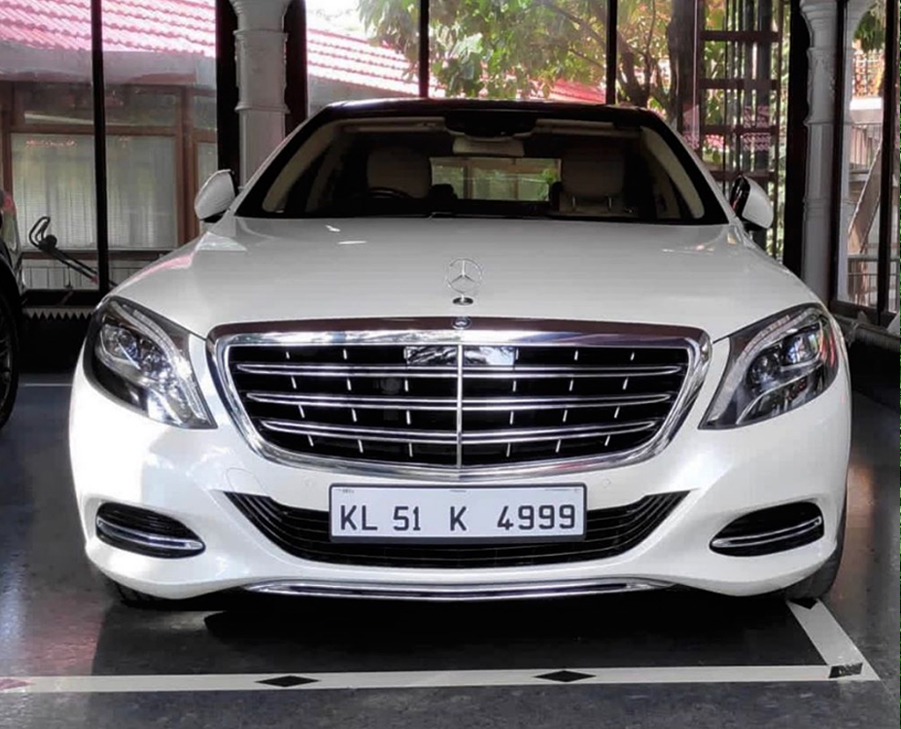

In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 14 - TEST Image')

In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

### 7. DE-NORMALIZE THE OUTPUT

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 3s 3s/step


array([[0.33517134, 0.59999853, 0.6632048 , 0.774815  ]], dtype=float32)

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[301.98937905, 540.59867889, 483.4762913 , 564.84015173]])

### 8. BOUNDING BOX

Draw bounding box on top of the image.

In [ ]:
coords = coords.astype(np.int32)
coords

array([[301, 540, 483, 564]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(301, 483) (540, 564)



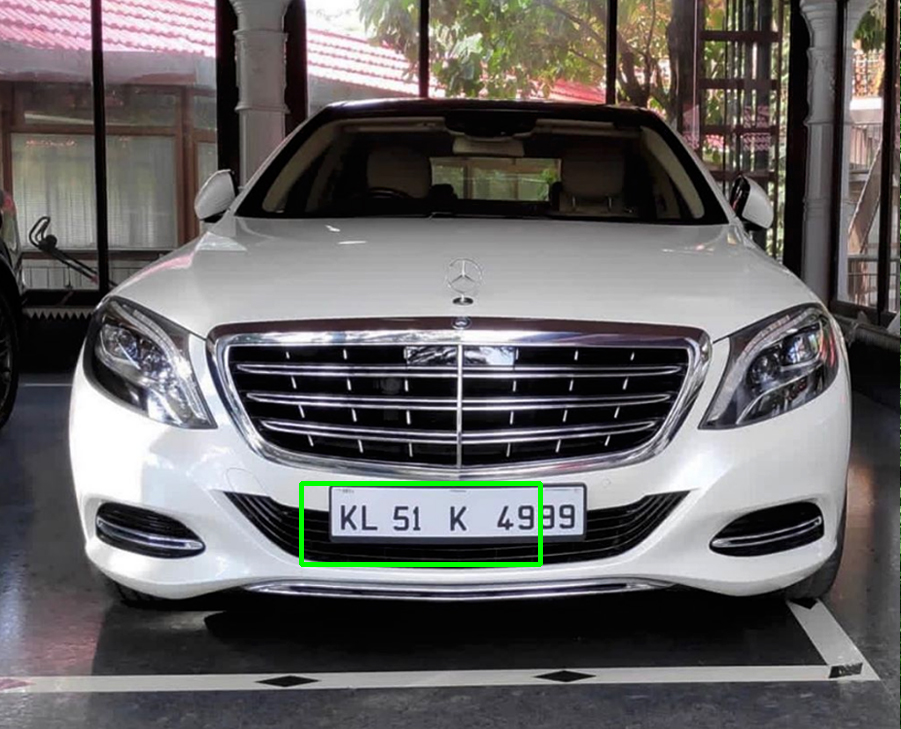

In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

### 9. CREATE PIPELINE

Return the image and coordinates of bounding box creating a function.

1/1 [==============================] - 0s 295ms/step
(301, 483) (540, 564)



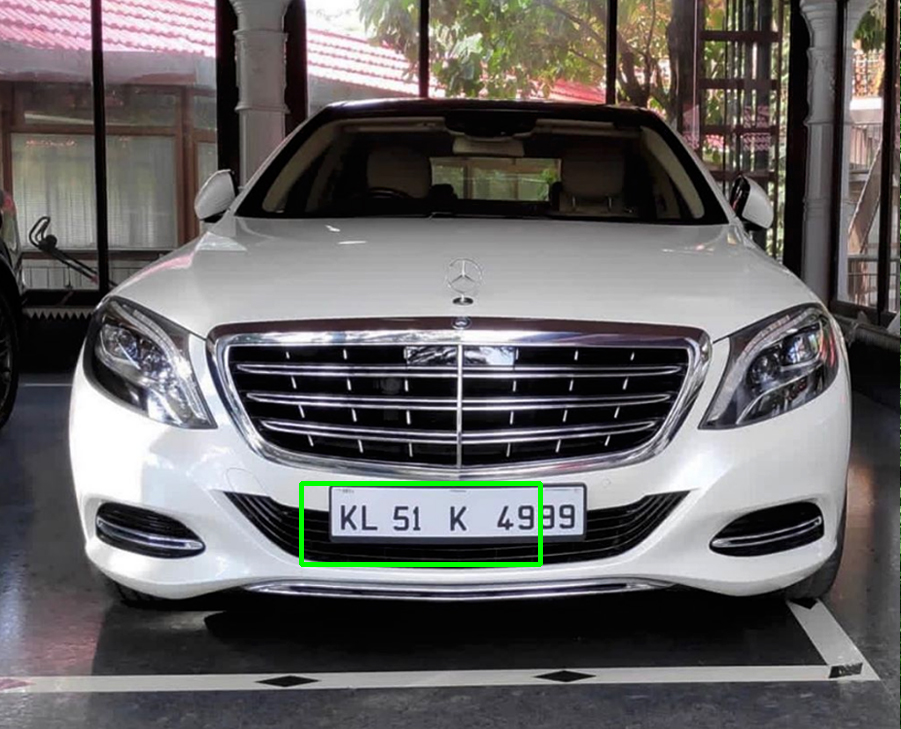

In [ ]:
# Create pipeline
path = '/content/number-plate-detection/TEST/TEST.jpeg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

### 10. EXTRACT NUMBER PLATE TEXT FROM IMAGE


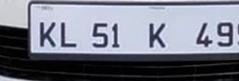

In [ ]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

#### With use of tesseract, we will extract the text from the image.


In [ ]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

TesseractNotFoundError: ignored

### 11. REAL TIME NUMBER PLATE RECOGNITIONT WITH YOLO


In [ ]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'../content/number-plate-detection/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,/content/number-plate-detection/images/N119.xml,180,559,216,314,../content/number-plate-detection/images/N119....,678,475
1,/content/number-plate-detection/images/N73.xml,124,209,102,130,../content/number-plate-detection/images/N73.jpeg,265,190
2,/content/number-plate-detection/images/N58.xml,221,430,190,231,../content/number-plate-detection/images/N58.jpeg,640,435
3,/content/number-plate-detection/images/N103.xml,813,1067,665,724,../content/number-plate-detection/images/N103....,1800,1200
4,/content/number-plate-detection/images/N6.xml,858,1122,611,676,../content/number-plate-detection/images/N6.jpeg,1920,1080


Now the next step is let me calculate the center_x, center_y, width and height, which is normalized to width and height. And as well normalize width and height of bounding box.

In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/number-plate-detection/images/N119.xml,180,559,216,314,../content/number-plate-detection/images/N119....,678,475,0.544985,0.557895,0.558997,0.206316
1,/content/number-plate-detection/images/N73.xml,124,209,102,130,../content/number-plate-detection/images/N73.jpeg,265,190,0.628302,0.610526,0.320755,0.147368
2,/content/number-plate-detection/images/N58.xml,221,430,190,231,../content/number-plate-detection/images/N58.jpeg,640,435,0.508594,0.483908,0.326562,0.094253
3,/content/number-plate-detection/images/N103.xml,813,1067,665,724,../content/number-plate-detection/images/N103....,1800,1200,0.522222,0.578750,0.141111,0.049167
4,/content/number-plate-detection/images/N6.xml,858,1122,611,676,../content/number-plate-detection/images/N6.jpeg,1920,1080,0.515625,0.595833,0.137500,0.060185


### 12. DATA PREPARATION

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14223, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 14223 (delta 11), reused 13 (delta 5), pack-reused 14194
Receiving objects: 100% (14223/14223), 13.29 MiB | 28.29 MiB/s, done.
Resolving deltas: 100% (9823/9823), done.


In [ ]:
!pip install -r ./yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 38.7 MB/s 


Make a Folder with description __data_images__ and __train__ and __test__. 
We will split data to train and split.

In [ ]:
mkdir /kaggle/working/yolov5/data_images/

mkdir: cannot create directory ‘/kaggle/working/yolov5/data_images/’: No such file or directory


In [ ]:
mkdir /kaggle/working/yolov5/data_images/test/

mkdir: cannot create directory ‘/kaggle/working/yolov5/data_images/test/’: No such file or directory


In [ ]:
mkdir /kaggle/working/yolov5/data_images/train/

mkdir: cannot create directory ‘/kaggle/working/yolov5/data_images/train/’: No such file or directory


In [ ]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

Copy each image into the folder train and test and generate .txt which has label info.

In [ ]:
train_folder = '/content/yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname, dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = '/content/yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

FileNotFoundError: ignored

### 13. TRAINING

Next step is basically train model.

In [ ]:
!python /content/yolov5/train.py --data ../input/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=../input/number-plate-detection/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Traceback (most recent call last):
  File "/content/yolov5/train.py", line 630, in <module>
    main(opt)
  File "/content/yolov5/train.py", line 499, in main
    check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.weights), str(opt.project)  # che

When model trained, we need to save our it in order to use it at OCR in onnx format as below:

In [ ]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v6.2-198-gacff977 Python-3.7.14 torch-1.12.1+cu113 CPU

Traceback (most recent call last):
  File "./yolov5/export.py", line 617, in <module>
    main(opt)
  File "./yolov5/export.py", line 612, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "./yolov5/export.py", line 494, in run
    model = attempt_load(weights, device=device, inplace=True, fuse=True)  # load FP32 model
  File "/content/yolov5/models/experimental.py", line 79, in attempt_load
    ckpt =

### 14. PREDICTING RESULTS FROM YOLO.

Let’s do some images settings which is important to provide in model construction.  Input settings we need to pass as 640 by 640.

In [4]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [5]:
# LOAD THE IMAGE
img = io.imread('/content/number-plate-detection/TEST/TEST.jpeg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

Now, we will load our YOLO model.

In [ ]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

error: ignored

In [ ]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [ ]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [ ]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [ ]:
# test
img = io.imread('/content/number-plate-detection/TEST/TEST.jpeg')
results = yolo_predictions(img,net)

NameError: ignored

In [ ]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

### CONCLUSION


With the increase in the number of vehicles, vehicle tracking has become an important research area for efficient traffic control, surveillance, and finding stolen cars. For this purpose, efficient real-time license plate detection and recognition are of great importance. Due to the variation in the background and font color, font style, size of the license plate, and non-standard characters, license plate recognition is a great challenge in developing countries. 
To overcome such issues, this study applies a deep-learning strategy to improve license plate recognition efficiency. The collected images have been captured under various lighting/contrast conditions, distance from the camera, varying angle of rotation, and validated to produce a high recognition rate. The approach can be effectively used by law enforcement agencies and private organizations to improve homeland security. 
Future work may include training and validation of the existing algorithm using the hybrid classifier method and improvement of the robustness of the license plate recognition system in varying weather conditions.